### The CartPole Problem using Q-Learning with a Gridded State Space

This notebook demonstrates the implementation of the Q-learning algorithm to solve the classic CartPole balancing problem. The state space is discretized into a grid, allowing a tabular Q-learning approach.

In [1]:
from CartPole.CPio import *
from CartPole.CPlearn import *
from CartPole.CPstates import *
from CartPole.CPutils import *

from matplotlib import pyplot as plt
import datetime
import gymnasium as gym

#### Key Q-learning Hyperparameters and State Space Configuration

Define the core hyperparameters for the Q-learning algorithm and the parameters for state space discretization:

- `n_episodes`: Total number of training episodes.
- `gamma`: Discount factor for future rewards (0 <= gamma <= 1). Controls the importance of future rewards.
- `epsilon`: Probability of exploration (epsilon-greedy strategy). Chance of taking a random action instead of the best-known action.
- `alpha`: Learning rate (0 < alpha <= 1). Controls how much new information overrides old information in Q-value updates.
- `nbins`: Number of bins to divide each dimension of the state space into.
- `a`: Extremal value for cart position.
- `b`: Extremal value for cart velocity.
- `c`: Extremal value for pole angle.
- `d`: Extremal value for pole angular velocity.
- `log_interval`: Frequency (in episodes) for printing training progress updates.

In [2]:
# Set job-specific parameters
n_episodes = 100000 # number of episodes to train

gamma = 0.9 # discount factor for future rewards
epsilon = 0.2 # probability of exploration
alpha = 0.1 # Q update fraction, learning rate

nbins = 20 # number of bins in each dimension
a = 0.4 # position extremal value
b = 2.0 # velocity extremal value
c = 0.3 # angular position extremal value
d = 0.1 # angular velocity extremal value

log_interval = 5000 # logging interval

#### Initialize Environment, Grid, Q-Table, and Logging Structures

Initialize the Gym environment (`CartPole-v1`), define the grid for state discretization using the `Grid` class, and create the initial Q-table (mapping state-action pairs to values) using `init_Q`. 

Also, set up structures to log training progress metrics for each episode:

- `game_length`: Stores the duration (number of steps) of each episode.
- `inf_norm`: Stores the infinity norm of the change in Q-values after each episode (measures the maximum change).
- `l2_norm`: Stores the L2 norm of the change in Q-values after each episode (measures the overall magnitude of change).
- `terminal_states`: A dictionary recording states encountered that led to episode termination.
- `visited_states`: A dictionary mapping discretized states to the number of times they were visited during training.

In [3]:
# initialize CartPole and set max steps per episode
env = gym.make('CartPole-v1')

# initialize Grid class to hold the edges of the observation space 
grid = Grid(nbins,a,b,c,d)

# initialize Q-values
Q = init_Q(grid)

# save information from each episode
game_length = [] # game_length for each episode
inf_norm = [] # infinity norm for change in Q values for each episode
l2_norm = [] # l2 norm on change in Q values for each episode
terminal_states = {} # a dictionary of states where done flag has been set
visited_states = {} # a dictionary that maps states to number of times visited

#### Q-Learning Main Training Loop

The main training loop iterates through `n_episodes`. In each episode, the `learn_Q` function (defined in `CPlearn.py`) is called. This function:
1. Simulates one episode of the agent interacting with the CartPole environment.
2. Uses an epsilon-greedy strategy for action selection (balancing exploration and exploitation).
3. Updates the Q-values in the `Q` table based on the transitions and rewards experienced, using the specified learning rate (`alpha`) and discount factor (`gamma`).
4. Updates the `visited_states` and `terminal_states` dictionaries.
5. Returns the length of the episode and the norms (infinity and L2) of the Q-value changes during that episode.

Training progress (episode number, episode length, timestamp) is printed periodically based on `log_interval`. Note that training time increases as the agent learns, because episodes become longer as the pole stays balanced for more steps.

In [4]:
# Caution: if n_episodes is large, this may take a while to run

begin = datetime.datetime.now()
for i in range(n_episodes+1):
    length, infnorm, l2norm = learn_Q(env,grid,gamma,epsilon,alpha,Q,visited_states,terminal_states)
    game_length.append(length)
    inf_norm.append(infnorm)
    l2_norm.append(l2norm)
    if i%log_interval == 0:
        print(f"{i:<8} {length:>5}  {str(datetime.datetime.now())}", flush=True)
end = datetime.datetime.now()
interval = end - begin

0           15  2025-05-02 23:37:05.596167
5000        13  2025-05-02 23:37:06.130573
10000       24  2025-05-02 23:37:06.821889
15000       16  2025-05-02 23:37:07.543980
20000       27  2025-05-02 23:37:08.314059
25000       24  2025-05-02 23:37:09.184162
30000       28  2025-05-02 23:37:10.176705
35000       46  2025-05-02 23:37:11.162039
40000       20  2025-05-02 23:37:12.210564
45000       25  2025-05-02 23:37:13.586295
50000       36  2025-05-02 23:37:15.159016
55000       56  2025-05-02 23:37:16.957871
60000       58  2025-05-02 23:37:18.971948
65000      104  2025-05-02 23:37:21.277135
70000       43  2025-05-02 23:37:23.358629
75000       46  2025-05-02 23:37:25.519104
80000       46  2025-05-02 23:37:27.818662
85000       29  2025-05-02 23:37:30.135198
90000       67  2025-05-02 23:37:32.626616
95000       29  2025-05-02 23:37:35.269460
100000      78  2025-05-02 23:37:37.968997


##### Print Training Time Information

Record and display the total time taken for the training process, along with the start and end timestamps.

In [5]:
print(f"Training time:        {interval}")
print(f"Training start time:  {begin}")
print(f"Training end time:    {end}")

Training time:        0:00:32.375044
Training start time:  2025-05-02 23:37:05.594821
Training end time:    2025-05-02 23:37:37.969865


#### Training Diagnostic Plots

Visualize the training progress using diagnostic plots. These plots help assess convergence and performance improvement over the training episodes. The plots show:

1.  **Episode Length Histogram:** Distribution of episode lengths achieved during training.
2.  **Episode Length vs. Episode Number:** Shows how the agent's ability to balance the pole (episode length) changes over time.
3.  **L2 Norm vs. Episode Number:** Tracks the overall magnitude of changes in the Q-table per episode. Convergence is indicated when this value approaches zero.
4.  **Infinity Norm vs. Episode Number:** Tracks the maximum change in any single Q-value per episode. Convergence is also indicated when this approaches zero.

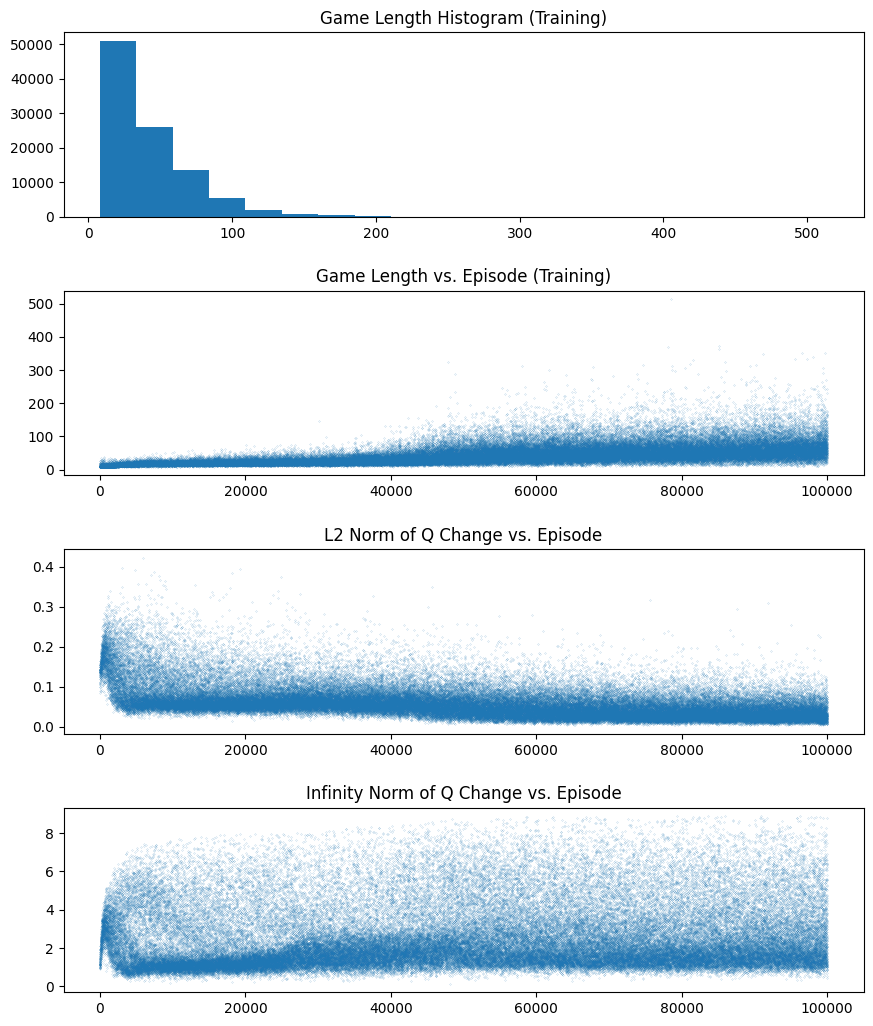

In [6]:
# create figures
_, axs = plt.subplots(4,figsize=(10,12))

plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.9,
                top=0.9,
                wspace=0.4,
                hspace=0.4)

axs[0].hist(game_length, 20)
axs[0].set_title("Game Length Histogram (Training)")

iter_vals = [x for x in range(len(inf_norm))]
axs[1].scatter(iter_vals,game_length,s=0.01)
axs[1].set_title("Game Length vs. Episode (Training)")

axs[2].scatter(iter_vals,l2_norm,s=0.01)
axs[2].set_title("L2 Norm of Q Change vs. Episode")

axs[3].scatter(iter_vals,inf_norm,s=0.01)
axs[3].set_title("Infinity Norm of Q Change vs. Episode")

plt.show()

#### Evaluating the Trained Policy

After training, evaluate the performance of the final learned policy (derived from the Q-table). This involves running the CartPole environment for a number of test episodes (`n_test_episodes`) without exploration (i.e., epsilon = 0). The agent will strictly follow the actions deemed optimal by the learned Q-table (`pi = Q_to_policy(grid, Q)`). The length of each test episode is recorded in the `rewards` list.

In [7]:
n_test_episodes = 10000

pi = Q_to_policy(grid,Q)
rewards = []
for i in range(n_test_episodes):
    reward, _ = play_game(env,grid,pi)
    rewards.append(reward)

#### Evaluation Results: Descriptive Statistics

Calculate and display descriptive statistics (mean, standard deviation, minimum, maximum, quartiles) for the episode lengths (`rewards`) achieved during the evaluation phase. This provides a quantitative summary of the trained policy's performance.

In [9]:
import pandas as pd
s = pd.Series(rewards)
s.describe()

count    10000.000000
mean       120.609700
std        342.319633
min         15.000000
25%         62.000000
50%         84.000000
75%        123.000000
max      24778.000000
dtype: float64

#### Evaluation Results: Figures

Plot the distribution and trend of episode lengths obtained during the evaluation phase:

1.  **Histogram:** Shows the frequency distribution of episode lengths achieved by the trained policy.
2.  **Scatter Plot:** Shows the length of each test episode versus the test episode number.

The maximum possible episode length in CartPole-v1 is often capped (e.g., 500 steps). If many episodes reach this maximum, the histogram might be skewed. You can adjust the `rewards_max` variable to focus the plot on a specific range of episode lengths for better visualization.

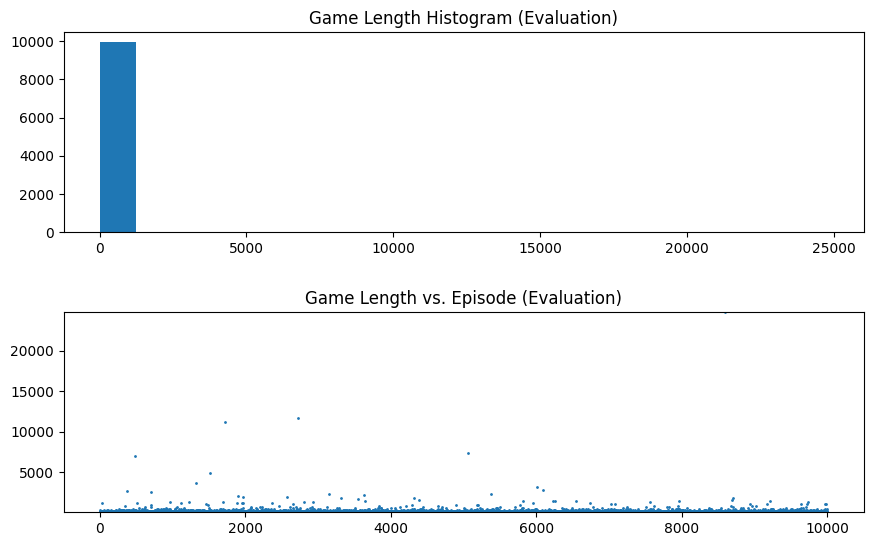

In [10]:
rewards_min = min(rewards)
rewards_max = max(rewards)
# rewards_max = 500 # Uncomment and adjust to zoom in on the histogram/scatter plot range
rewards_range = (rewards_min,rewards_max)

_, axs = plt.subplots(2,figsize=(10,6))

plt.subplots_adjust(left=0.1,
                bottom=0.1,
                right=0.9,
                top=0.9,
                wspace=0.4,
                hspace=0.4)

axs[0].hist(rewards, 20, range=rewards_range)
axs[0].set_title("Game Length Histogram (Evaluation)")

iter_vals = [x for x in range(len(rewards))]
axs[1].scatter(iter_vals,rewards,s=1)
axs[1].set_ylim(rewards_range)
axs[1].set_title("Game Length vs. Episode (Evaluation)")

plt.show()